In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/test/test/testX.pt
/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/train/train/trainY.pt
/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/train/train/trainX.pt


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")

In [3]:
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

trainx = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/train/train/trainX.pt')
trainy = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/train/train/trainY.pt')
testx = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/test/test/testX.pt')

num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import cv2
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

In [4]:
class LazyLoadDataset(Dataset):
    def __init__(self,path,train=True,transform=None):
        self.transform=transform
        path=path+("train/" if train else "test/")
    
        self.pathX=path+"X/"
        self.pathY=path+"Y/"
        
        self.data=os.listdir(self.pathX)
    
    def __getitem__(self,idx):
        f=self.data[idx]
    
        img0=cv2.imread(self.pathX+f+"/rgb/0.png")
        img1=cv2.imread(self.pathX+f+"/rgb/1.png")
        img2=cv2.imread(self.pathX+f+"/rgb/2.png")
        if self.transform is not None:
            img0=self.transform(img0)
            img1=self.transform(img1)
            img2=self.transform(img2)

        depth=np.load(self.pathX+f+"/depth.npy")

        field_id=pkl.load(open(self.pathX+f+"/field_id.pkl","rb"))
        #Y
        Y=np.load(self.pathY+f+".npy")
    
        img0=cv2.normalize(img0, None, alpha=0, beta=1,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img1=cv2.normalize(img1, None, alpha=0, beta=1,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img2=cv2.normalize(img2, None, alpha=0, beta=1,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        depth=cv2.normalize(depth/1000, None, alpha=0, beta=1,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return (img0,img1,img2,depth,field_id),Y

    def __len__(self):
        return len(self.data)

In [5]:
train_dataset=LazyLoadDataset("lazydata/")
train_dataset.__len__()

3396

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True)

In [7]:
a=next(iter(train_loader))
a[0][0].split(1,dim=3)[0].squeeze().shape, a[0][0][0][:,:,1].shape

(torch.Size([64, 224, 224]), torch.Size([224, 224]))

In [8]:
tt=torch.stack((a[0][0][:,:,:,0],a[0][0][:,:,:,1],a[0][0][:,:,:,2],
                a[0][1][:,:,:,0],a[0][1][:,:,:,1],a[0][1][:,:,:,2],
                a[0][2][:,:,:,0],a[0][2][:,:,:,1],a[0][2][:,:,:,2]),1)
tt.shape

torch.Size([64, 9, 224, 224])

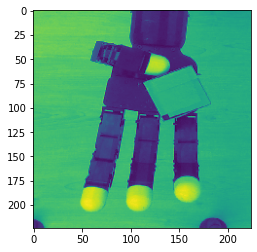

In [9]:
plt.imshow(tt[0,1,:,:])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
print(device)

cuda:0


In [11]:
def train(epoch, model, optimizer):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):


        RGBs=torch.stack((data[0][:,:,:,0],data[0][:,:,:,1],data[0][:,:,:,2],
                          data[1][:,:,:,0],data[1][:,:,:,1],data[1][:,:,:,2],
                          data[2][:,:,:,0],data[2][:,:,:,1],data[2][:,:,:,2]),1)

        data=torch.cat((RGBs,data[3]), 1)
        data, target = data.to(device), target.to(device)
        target=target*1000
        output = model(data)
        mse_loss = nn.MSELoss()
        loss = mse_loss(output.float(), target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        target=target/1000

In [12]:
from torchvision.models import resnet50
res50=resnet50()
res50.float()
res50.conv1=nn.Conv2d(12,64,kernel_size=7,stride=2,padding=3,bias=False)
res50.fc=nn.Linear(in_features=2048,out_features=12)

In [13]:
res50.to(device)

optimizer= torch.optim.Adam(res50.parameters())


test_accuracy = []
for epoch in range(0, 30):
    train(epoch, res50, optimizer)

Train Epoch: 0 [0/3396 (0%)]	Loss: 4411.407715
Train Epoch: 0 [640/3396 (19%)]	Loss: 1638.886108
Train Epoch: 0 [1280/3396 (37%)]	Loss: 656.223938
Train Epoch: 0 [1920/3396 (56%)]	Loss: 376.205261
Train Epoch: 0 [2560/3396 (74%)]	Loss: 315.637817
Train Epoch: 0 [3200/3396 (93%)]	Loss: 247.031158
Train Epoch: 1 [0/3396 (0%)]	Loss: 228.249664
Train Epoch: 1 [640/3396 (19%)]	Loss: 190.224289
Train Epoch: 1 [1280/3396 (37%)]	Loss: 177.539673
Train Epoch: 1 [1920/3396 (56%)]	Loss: 143.011261
Train Epoch: 1 [2560/3396 (74%)]	Loss: 130.429565
Train Epoch: 1 [3200/3396 (93%)]	Loss: 138.008362
Train Epoch: 2 [0/3396 (0%)]	Loss: 145.467194
Train Epoch: 2 [640/3396 (19%)]	Loss: 155.685226
Train Epoch: 2 [1280/3396 (37%)]	Loss: 111.902573
Train Epoch: 2 [1920/3396 (56%)]	Loss: 101.950562
Train Epoch: 2 [2560/3396 (74%)]	Loss: 117.932800
Train Epoch: 2 [3200/3396 (93%)]	Loss: 75.907684
Train Epoch: 3 [0/3396 (0%)]	Loss: 92.756493
Train Epoch: 3 [640/3396 (19%)]	Loss: 85.625999
Train Epoch: 3 [1280/

In [14]:
torch.save(res50.state_dict(), "model_res50_record_3.pt")

In [15]:
from torchvision.models import resnet50
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
res=resnet50()
res.float()
res.conv1=nn.Conv2d(12,64,kernel_size=7,stride=2,padding=3,bias=False)
res.fc=nn.Linear(in_features=2048,out_features=12)
res.to(device)
model = res
model.load_state_dict(torch.load('model_res50_record_3.pt'))


<All keys matched successfully>

In [16]:
test_data = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/test/test/testX.pt')
file_ids = test_data[-1]
depth_data=test_data[1]
rgb_data = test_data[0]

In [17]:
new_test=torch.cat((rgb_data[:,0],rgb_data[:,1],rgb_data[:,2],depth_data),dim=1)

In [18]:
split_test=torch.split(new_test,50,dim=0)
len(split_test)

17

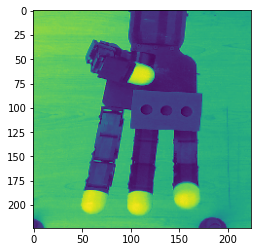

In [19]:
plt.imshow(new_test[0,1,:,:])

In [20]:
split_test[0].shape

torch.Size([50, 12, 224, 224])

In [21]:
preds = []
for data in split_test:

    output = res(data.to('cuda'))
    preds.append(output.cpu().detach().numpy())
    del output
    torch.cuda.empty_cache()

In [22]:
np.concatenate(preds)/1000

array([[ 0.05046181,  0.050768  ,  0.10745417, ...,  0.05741148,
         0.05154715, -0.035712  ],
       [ 0.032991  ,  0.0534572 ,  0.1252096 , ...,  0.04445301,
         0.0357029 , -0.04543431],
       [ 0.04434367,  0.05230781,  0.11531883, ...,  0.05116883,
         0.01971737, -0.06207   ],
       ...,
       [ 0.04278338,  0.05286096,  0.11688663, ...,  0.04531453,
         0.04960248, -0.03279136],
       [ 0.04248276,  0.04939075,  0.10689045, ...,  0.05114422,
         0.01348252, -0.06245403],
       [ 0.04168454,  0.05167144,  0.11653403, ...,  0.05130493,
         0.04331272, -0.02763938]], dtype=float32)

In [23]:
np.concatenate(preds).shape

(849, 12)

In [24]:
import pickle
import pandas as pd
# model=model_cnn
outfile = 'submission11.csv'
output_file = open(outfile, 'w')
titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
 'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10',
'FINGER_POS_11', 'FINGER_POS_12']
df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(np.concatenate(preds)/1000)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission11.csv


In [ ]:
df.head()